# Event Extraction
Event Extraction is the process of gathering knowledge about periodical incidents found in texts. Once we identify an event, we can perform a variety of useful analyses such as gathering information about what happened. when it happened, who was involved, etc.

Consider the fact that *identifying an event* is the first step towards deriving any form of meaningful insight from them. Furthermore, when we summarize an article, blog, or text, it is practical to do so by referring to the events which transpired within them. Now knowing the value of **Event Extraction** let's walk through the process of taking a text corpus and producing a list of the events within.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

## Import Data
We will use **[newsapi](https://newsapi.org/)** to acquire our text data. 

News API is a simple HTTP REST API for searching and retrieving live articles from the web. We can search with any combination of the following criteria:
- **Keyword or Phrase**: e.g find all all articles containing the word 'Microsoft'.
- **Date published**
- **Source name**: e.g. find all articles by a specific outlet
- **Source domain name**: e.g. find all articles published on nytimes.com
- **Language**: e.g. find all articles writtein in English.

Results can be sorted by date published, relevancy to keyword, popularity of source. 


Below we recreate the functions to access the API as seen on the medium article.

In [2]:
from newsapi import NewsApiClient
from tqdm import tqdm #progress bar library
from datetime import datetime, timedelta

newsapi = NewsApiClient(api_key='b0d0ef32fe63459693f4e47ff985cfc0')

In [3]:
#some functions from the medium article
def get_past_articles(past=30):
    '''
    
    
    '''
    past_articles = dict()
    for past_days in range(1, past):
        from_day = str(datetime.now() - timedelta(days=past_days))
        to_day = str(datetime.now() - timedelta(days=past_days -1))
        past_articles.update({from_day:to_day})
    return past_articles

def get_articles(query, past=30):
    past_articles = get_past_articles(past)
    all_articles = []
    for i, j in tqdm(past_articles.items()):
        for pag in tqdm(range(1,6)):
            pag_articles = newsapi.get_everything(q=query,language='en',
                                                  from_param=i, to=j,
                                                  sort_by='relevancy',page=pag)['articles']
            if len(pag_articles) == 0:
                break
            all_articles.extend(pag_articles)
    return all_articles

Only run the below cell if you haven't stored your pickle yet or want to change your search

In [ ]:
# articles = get_articles('Carbon Tax',past=30)
# df = pd.DataFrame(articles)
# df.to_pickle('../../../data/newsapi.pkl')

In [4]:
df = pd.read_pickle('../../../data/newsapi.pkl')

In [5]:
df.describe()

,author,content,description,publishedAt,source,title,url,urlToImage
count,1283,1467,1477,1486,1486,1486,1486,1407
unique,822,1387,1377,1366,350,1315,1485,1228
top,https://www.facebook.com/DailyMail,"In 2005, a decade before he would launch the s...","It's an online form of currency and, yet, it's...",2019-06-25T12:00:59Z,"{'id': 'cbc-news', 'name': 'CBC News'}",Electric planes start small as industry wrestl...,https://www.seattletimes.com/seattle-news/poli...,https://s.yimg.com/os/mit/media/m/social/image...
freq,24,8,6,7,55,9,2,18


We can see above that we have many articles, with some missing entries for authors and descriptions. 

Let us take a look at what each column contains.

In [6]:
for col in df.columns:
    print(col)
    print(df[col].values[0])
    print()

author
David Baxter

content
Canadas premiers are meeting in Saskatoon, focusing on economic development in their Wednesday session. However, there is still a key issue at the table  pipelines.
Prior to the meeting, Council of the Federation (COF) chair and Saskatchewan Premier Scott Mo… [+3647 chars]

description
Oil pipelines remain contentious as more provinces opposed to federal carbon tax Global News Trudeau needs to get 'Buy America' exemption to stave off job losses: premiers CBC News AFN Chief Calls 40,000 Indigenous Children In Care A Human Rights Issue HuffPo…

publishedAt
2019-07-10T21:03:00Z

source
{'id': None, 'name': 'Globalnews.ca'}

title
Oil pipelines remain contentious as more provinces opposed to federal carbon tax - Global News

url
https://globalnews.ca/news/5480974/pipelines-provinces-federal-carbon-tax/

urlToImage
https://shawglobalnews.files.wordpress.com/2019/07/21419916.jpg?quality=70&strip=all&w=720&h=379&crop=1



Much like the Medium tutorial, let us first focus on working with our titles. That way our processing time will be significantly less, and we can understand the workflow before extending ot analysing events for the entire corpus. In this tutorial they do not preprocess, which gives us the perfect opportunity to set up our own preprocessing pipeline! 

It appears as though 'content' aims to be the text contained in the article, but NewsAPI cuts off after a few sentences. 'Description' is a brief summary, presumably provided by the publisher.

These may become useful later. For now, lets create a dataframe with only the titles, dates, and descriptions.

In [7]:
df = df[['title','publishedAt','description']]
df.describe()

,title,publishedAt,description
count,1486,1486,1477
unique,1315,1366,1377
top,Electric planes start small as industry wrestl...,2019-06-25T12:00:59Z,"It's an online form of currency and, yet, it's..."
freq,9,7,6


In [8]:
#drop rows with duplicate titles and drop empty 'na' values
df = df.drop_duplicates(subset='title').reset_index(drop=True)
df = df.dropna()
df.describe()

,title,publishedAt,description
count,1306,1306,1306
unique,1306,1262,1284
top,Oil pipelines remain contentious as more provi...,2019-06-18T01:30:00Z,
freq,1,3,5


We can see in dropping duplicates and empty values we removed some articles.

We will skip past preprocessing and immediately use a pre-trained word representation model. If we were valuing performance, we would use SpaCy's large model with 685k English words, `en_core_web_lg`.

**NOTE:** `en_core_web_lg` is a 850 MB+ file, so you can use a smaller one for this example: `en_core_web_sm` which is 10MB. You can find a list of all models [here](https://spacy.io/models/en)

If you want to load `en_core_web_sm` you will need to enter your preferred coding environment and type into terminal.: 

```
python -m spacy download en_core_web_sm
```

In the meantime, I went all out and downloaded the large model so let's see how it goes!

In [9]:
import spacy
nlp = spacy.load('en_core_web_lg')

The object `nlp` now is able to wrap around any string and provide us with its vector according to the pre-trained `en_core_web_lg`. For example:

In [16]:
nlp('I love bananas').vector

array([ 3.55766602e-02,  3.03386003e-01, -2.81356335e-01, -3.81086677e-01,
       -9.91786718e-02,  2.16976658e-01, -4.04500179e-02, -2.57583320e-01,
        1.06113672e-01,  1.37844336e+00, -5.17866671e-01,  1.22420669e-01,
        1.91259995e-01,  1.33633316e-02, -1.86933324e-01, -8.34139958e-02,
       -1.64890006e-01,  9.18296635e-01, -1.07690014e-01,  2.69199997e-01,
        3.19396645e-01, -4.52770106e-02,  4.80006129e-04, -3.84383313e-02,
       -1.77996662e-02, -1.89677671e-01,  8.50600004e-03, -3.46013308e-01,
        1.32152110e-01, -2.76154011e-01, -5.08249998e-02,  1.45194784e-01,
       -4.48366590e-02,  2.63023347e-01, -1.08049959e-02,  5.68770058e-02,
        1.25836998e-01, -9.91870090e-02, -5.20579994e-01,  1.28257379e-01,
       -9.13520083e-02, -1.43583342e-01, -6.75736666e-02,  2.20445678e-01,
       -1.58183333e-02,  4.70750004e-01, -2.19280362e-01,  2.39253327e-01,
        1.34416342e-01,  5.87116666e-02, -1.85461000e-01, -2.22413335e-02,
        5.07866824e-03, -

Let's now vectorize each title and add it to a list called `docs`. 

In [10]:
sentence_vecs = {}
docs = []

for title in tqdm(df.title):
    doc = nlp(title)
    docs.append(doc)
    sentence_vecs.update({title: doc.vector})

100%|██████████| 1306/1306 [00:09<00:00, 137.99it/s]


We will store the respective sentences and vectors in lists of their own.

In [19]:
sentences = list(sentence_vecs.keys())
vectors = list(sentence_vecs.values())

We saw above what a single vector looks like. This language model encodes each word in a 300-dimensional vector. 

In [22]:
print(len(vectors[11]))

300


## Cluster the Vectors
We have now completed the noble work of transforming our article titles into a form which is processable by our models. To understand what to do with our vector-embedded sentences we will have to think a few steps ahead.

Let's take a moment to remind ourselves of the end game. What we're after is the recognition of an event from a collection of article headlines. To reframe the problem, to find an event we must be able *to discard all non-events*. Our intuition tells us that frequency may be a good measure of whether or not an event occured. After all, we imagine that the vast majority of our headlines are one-offs, but if a grouping of similar headlines has a high enough population this may be an indicator of multiple outlets picking up on the same occurence.

The problem of grouping our headlines together and counting their population size is the problem of **clustering**. This unsupervised learning technique will find the natural structure of our dataset. Finding structure essentially means finding groups for which members of that group are more similar to each other than to non-members.  

As our sentences have been vector-embedded, we expect articles of similar topics to cluster together and belong to the same group, and to be separated from unrelated articles. Here, we will use scikit-learn's `DBSCAN` algorithm.

This clustering algorithm is in the family of *density based clustering algorithms*. Unlike a more commonly used algorithm such as kmeans, it does not require that we specify the number of clusters beforehand. Keep in mind that the algorithm that you use is a design decision in this process and *will* affect the out come. As such, I highly recommend you try different algorithms to see the results.

In [24]:
from sklearn.cluster import DBSCAN

Below we perform a hyperparameter sweep over the `eps` argument in DBSCAN. Read DBSCAN's documentation in scikit-learn to understand what it does in depth.

In [25]:
x = np.array(vectors)
n_classes = {}

for i in tqdm(np.arange(0.001, 1, 0.002)):
    dbscan = DBSCAN(eps=i, min_samples=2, 
                    metric='cosine').fit(x)
    n_classes.update({i: len(pd.Series(dbscan.labels_).value_counts())})

100%|██████████| 500/500 [00:11<00:00, 39.63it/s]


Make chart showing the number of clusters.

In [26]:
#import plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
#Process the dictionary we made into a dataframe
cluster_df = pd.DataFrame.from_dict(n_classes, orient='index')
cluster_df['epsilon'] = cluster_df.index.values
cluster_df.columns = ['num_clusters','epsilon']
cluster_df.index=range(len(cluster_df))

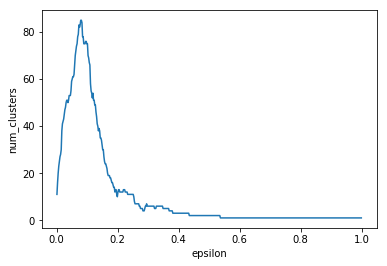

In [28]:
ax = sns.lineplot(x="epsilon",y='num_clusters',
                  data=cluster_df)

For the sake of this demo, let us use the epsilon value which provides us with the most clusters. To do so, we will first locate it's index.

There is no intrinsic reason that the epsilon value with the most clusters would benefit us in solving this problem. At a moment's thought we can see that it will guarantee that non-similar titles are not grouped together. In a more thorough problem setting we might perform some analysis to see how well a selection of the appropriate epsilon values clusters the titles according to our own human insight.

For now we will maximize the number of clusters.

In [31]:
idx = np.argmax(cluster_df.num_clusters.values)

In [32]:
print(cluster_df.epsilon.values[idx])

0.079


Let's choose our epsilon value to be 0.07 then

In [33]:
dbscan = DBSCAN(eps=0.079, min_samples=2, metric='cosine').fit(x)

In [34]:
pd.Series(dbscan.labels_).value_counts()[:8]

-1     1022
 1       68
 26      10
 35       8
 71       8
 29       6
 9        5
 3        5
dtype: int64

Above we can see our most common classes. It is important to note that the value of '-1' is assigned to clusters with single elements within them. So truly, our most popular class is '1'.

Let's take a look at what the headlines in one of these look like.

In [35]:
#make a dataframe where each row has the headline and its corresponding cluster label
results = pd.DataFrame({'label':dbscan.labels_,'sentences':sentences})

#sort out all headlines that are in cluster 39
examples = results[results.label == 26]
examples = examples.sentences.tolist() #get a list of all headlines 

#get a dataframe of all events which correspond to cluster 39
#return the date and title of every article which is in cluster 39
event_df = df[df.title.isin(examples)][['publishedAt','title']] 
event_df = event_df.sort_values(by='publishedAt').dropna()

In [36]:
event_df.head()

,publishedAt,title
891,2019-06-20T19:14:50Z,Alberta asks Court of Appeal to rule on federa...
914,2019-06-21T08:22:31Z,Alberta asks Court of Appeal to look at consti...
560,2019-06-26T15:06:08Z,Ontario's top court to rule on constitutionali...
573,2019-06-26T19:16:40Z,Ontario’s top court to rule on constitutionali...
473,2019-06-28T08:00:00Z,Ontario's top court set to rule on whether fed...


By following the above process for all clusters which are not -1, we end up with a dataframe of events. We can choose to filter them by time and relevance. In this example, we can display one article per day so the timeline is clean and consistent.

However, we run into the issue that there are many titles on the same topic each day. We need a criterium to pick one of the titles, ideally the title which is most representative of the event. To do so, we will group the daily sentences and for each group (or cluster) choose the one closest to the center of the cluster. In this sense, we are choosing the 'average sentence'.

In [39]:
from sklearn.metrics import pairwise_distances_argmin_min

def get_mean_vector(sentences):
    a = np.zeros(300) #create an array of zeros
    for sent in sentences:
        a += nlp(sent).vector #vectorize this sentence
    return a/len(sentences) #return the average

def get_central_vector(sentences):
    vecs = []
    for sent in sentences:
        doc = nlp(sent)
        vecs.append(doc.vector)
    mean_vec = get_mean_vector(sentences)
    index = pairwise_distances_argmin_min(np.array([mean_vec]),vecs)[0][0]
    return sentences[index]

Let's run this on our current dataframe to see what happens

In [40]:
get_central_vector(event_df.title.values)

'Ontario’s top court to rule on constitutionality of federal carbon tax'

Let's try this summarization for our 10 most common clusters

Int64Index([1, 26, 35, 71, 29, 9, 3, 77, 36, 69], dtype='int64')

In [53]:
def summarize_events(dbscan, sentences, num_events):
    results = pd.DataFrame({'label':dbscan.labels_,'sentences':sentences})
    clusters = pd.Series(dbscan.labels_).value_counts()[1:1+num_events] #we go [1:1+num_events] to omit cluster -1
    clusters = clusters.index.values.astype(int) #get the index values (which store the cluster label)
    
    for cluster in clusters:
        #list of all headlines
        examples = results[results.label == cluster].sentences.tolist()
        event_df = df[df.title.isin(examples)][['publishedAt','title']] 
        event_df = event_df.sort_values(by='publishedAt').dropna()
        print('Cluster:',cluster)
        print(get_central_vector(event_df.title.values))
        print()

In [56]:
summarize_events(dbscan,sentences,15)

Cluster: 1
Blink and you'll miss it: Where was climate change in the Democratic debates? - Fast Company

Cluster: 26
Ontario’s top court to rule on constitutionality of federal carbon tax

Cluster: 35
Oregon Republican senators end walkout over climate-change bill

Cluster: 71
Oregon governor sends police after GOP senators who fled Capitol

Cluster: 29
Climate Politics/Capitol Light (11)

Cluster: 9
Are Democrats ceding the center to Trump?

Cluster: 3
2:00PM Water Cooler 6/17/2019

Cluster: 77
Federal carbon tax would have to double to meet Canada’s climate-change commitments, report says

Cluster: 36
2020 Ford Mustang Shelby GT500 Pricing Starts At $70,300

Cluster: 69
Under pressure, plane industry vows cleaner flight — someday

Cluster: 17
Overnight Energy: Trump touts environmental policies, but says nothing of climate change| Environmental groups fight EPA's new FOIA rule| Health groups sue over Trump rollback of Obama-era emissions rule

Cluster: 16
P.E.I., Quebec intervene in 

Personally I'm not too impressed with this walkthrough of event recognition. It seems to be heavily reliant on the titles telling the truth in the first place.

There are some interesting concepts here, namely:
- Using the clustering of embedded vectors as a method of finding consensus across many samples